In [2]:
from matplotlib import pyplot as plt
from matplotlib import rc
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import seaborn as sns

rc("pdf", fonttype=42)

In [2]:
# load the dreadd data
dreadd_df = pd.read_csv('./DREADD/dreadd_pellet_handling_mode.csv')
animals = dreadd_df['animal'].unique()

animal_names = []
exp_group = []
frac_primary_dir_mean = []
frac_primary_dir_single = []
frac_primary_paw_mean = []
frac_primary_paw_single = []

# create dataframes for the dreadd data where the CNO groups are averaged
# or just the first CNO trial is taken
for a in animals:
    df = dreadd_df.loc[dreadd_df['animal'] == a]

    dir_baseline = df.loc[df['day'] == 'baseline']['frac_primary_dir'].values[0]
    dir_cno1 = df.loc[df['day'] == 'CNO1']['frac_primary_dir'].values[0]
    dir_cno2 = df.loc[df['day'] == 'CNO2']['frac_primary_dir'].values[0]
    dir_cno_mean = np.mean([dir_cno1, dir_cno2])
    
    paw_baseline = df.loc[df['day'] == 'baseline']['frac_primary_paw'].values[0]
    paw_cno1 = df.loc[df['day'] == 'CNO1']['frac_primary_paw'].values[0]
    paw_cno2 = df.loc[df['day'] == 'CNO2']['frac_primary_paw'].values[0]
    paw_cno_mean = np.mean([paw_cno1, paw_cno2])
    
    # add the baseline value
    animal_names.append(a)
    exp_group.append('baseline')
    frac_primary_dir_mean.append(dir_baseline)
    frac_primary_dir_single.append(dir_baseline)
    frac_primary_paw_mean.append(paw_baseline)
    frac_primary_paw_single.append(paw_baseline)
    
    # add the inhibition value
    animal_names.append(a)
    exp_group.append('inhib')
    frac_primary_dir_mean.append(dir_cno_mean)
    frac_primary_dir_single.append(dir_cno1)
    frac_primary_paw_mean.append(paw_cno_mean)
    frac_primary_paw_single.append(paw_cno1)
    
    
method_name = len(animal_names) * ['DREADD']
    
mean_dread_df = pd.DataFrame(
    {
        'animal': animal_names,
        'exp_group': exp_group,
        'frac_primary_dir': frac_primary_dir_mean,
        'frac_primary_paw': frac_primary_paw_mean,
        'method': method_name
    }
)

single_dread_df = pd.DataFrame(
    {
        'animal': animal_names,
        'exp_group': exp_group,
        'frac_primary_dir': frac_primary_dir_single,
        'frac_primary_paw': frac_primary_paw_single,
        'method': method_name
    }
)



In [3]:
# load the dtr data
dtr_df = pd.read_csv('./DTR/dtr_pellet_handling_mode.csv')


# drop day 10 and only keep columns in dreadd df
dtr_df = dtr_df.loc[dtr_df['day'] != 10][['animal', 'exp_group', 'frac_primary_dir', 'frac_primary_paw']]

# add method column
dtr_df['method'] = 'DTR'

In [4]:
# combine the dataframes
dtr_dreadd_single = pd.concat([dtr_df, single_dread_df])
dtr_dreadd_mean = pd.concat([dtr_df, mean_dread_df])


In [95]:
def compare_methods(data, column):
    # baseline
    baseline_dtr = data.loc[(data['method'] == 'DTR') & (data['exp_group'] == 'baseline')][column].values
    baseline_dreadd = data.loc[(data['method'] == 'DREADD') & (data['exp_group'] == 'baseline')][column].values
    _, baseline_p_value = stats.mannwhitneyu(baseline_dtr, baseline_dreadd)
    
    # inhib
    inhib_dtr = data.loc[(data['method'] == 'DTR') & (data['exp_group'] == 'inhib')][column].values
    inhib_dreadd = data.loc[(data['method'] == 'DREADD') & (data['exp_group'] == 'inhib')][column].values
    _, inhib_p_value = stats.mannwhitneyu(inhib_dtr, inhib_dreadd)
    
    p_values = {
        'baseline': baseline_p_value,
        'inhib': inhib_p_value
    }
    
    return p_values

def make_barplot(data, column, column_label):
    f, ax = plt.subplots(figsize=(10, 10))
    
    ax = sns.barplot(
        x="exp_group",
        y=column,
        data=data,
        facecolor=(0, 0, 0, 0.25),
        edgecolor=(0, 0, 0, 1),
        ci="sd",
        capsize=0.1
    )
    ax = sns.stripplot(x="exp_group", y=column ,hue='animal', data=data, ax=ax, size=12, jitter=False)

    ax.set_ylabel(column_label, fontsize = 20, family='Arial')
    ax.set_xlabel('Experimental group', fontsize = 20, family='Arial')
    ax.set_ylim()

    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    
    
    return f, ax

In [6]:
def compare_dists(data_by_animal, column):
    df = data_by_animal[column]
    
    baseline = df['baseline'].values
    inhib = df['inhib'].values
    
    _, p_value = stats.wilcoxon(baseline, inhib)
    
    return p_value

In [7]:
def process_handling_metric(data, metric, metric_label):
    method_p_values = compare_methods(data, metric)
    f, ax = make_barplot(data, metric, metric_label)
    
    for k, v in method_p_values.items():
        print(f'{k} p value: {v:.3f}')

    data_by_animal = data.pivot(index='animal', columns='exp_group')
    baseline_inhib_p_value = compare_dists(data_by_animal, metric)
    
    print(f'baseline-inhib p-value: {baseline_inhib_p_value:.3f}')
    
    return baseline_inhib_p_value, method_p_values, f, ax

baseline p value: 0.191
inhib p value: 0.331
baseline-inhib p-value: 0.028


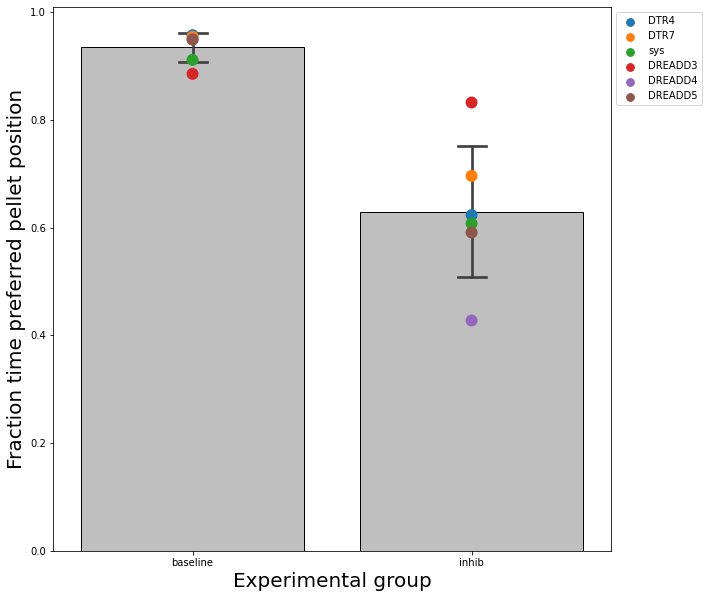

In [10]:
_, _, f_dir, _ = process_handling_metric(dtr_dreadd_mean, 'frac_primary_dir', 'Fraction time preferred pellet position')
f_dir.savefig('dtr_dreadd_pellet_pos_barplot.png', dpi=300, bbox_inches='tight')
f_dir.savefig('dtr_dreadd_pellet_pos_barplot.pdf', dpi=300, bbox_inches='tight')

baseline p value: 0.331
inhib p value: 0.331
baseline-inhib p-value: 0.028


/Users/yamauc0000/Documents/PoseProcessor/.venv/lib/python3.7/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


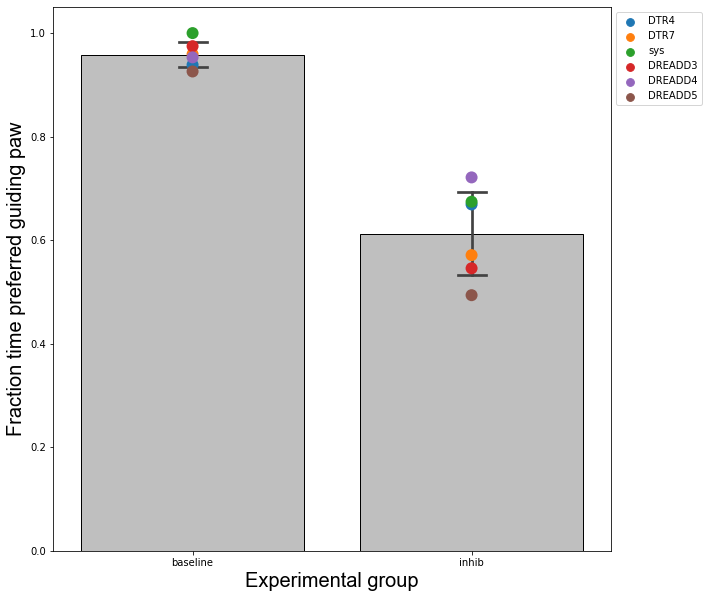

In [111]:
_, _, f_paw, _ = process_handling_metric(dtr_dreadd_mean, 'frac_primary_paw', 'Fraction time preferred guiding paw')

f_paw.savefig('dtr_dreadd_guiding_paw_barplot.png', dpi=300, bbox_inches='tight')
f_paw.savefig('dtr_dreadd_guiding_paw_barplot.pdf', bbox_inches='tight')

# Angle histograms

In [2]:
# load the DREADD data
dreadd_df = pd.read_csv('./DREADD/full_df_leading_paw_clean.csv')
dreadd_animals = ['DREADD3', 'DREADD4', 'DREADD5']
dreadd_df_good_animals = dreadd_df.loc[dreadd_df.animal_name.isin(dreadd_animals)]


# load the dtr data
dtr_data = pd.read_csv('./DTR/full_df_leading_paw_clean.csv')

# combine the dataframes
full_df = pd.concat([dreadd_df_good_animals, dtr_data])

In [3]:
full_df['dots_labeled'] = full_df['bluedot_labeled'] & full_df['reddot_labeled']
labeled_pellet_df = full_df.loc[(full_df['handling'] == True) & (full_df['dots_labeled'] == True)]

In [9]:
pellet_angles = full_df['pellet_angle'].values
offset_angles = np.zeros_like(pellet_angles)

for a in full_df['animal_name'].unique():
    # get the baseline name
    if 'DREADD' in a:
        baseline_name = 'baseline'
    else:
        baseline_name = 0
    
    animal_indices = full_df['animal_name'] == a
    
    # get the baseline angle
    animal_df = full_df.loc[animal_indices]
    baseline_angle = labeled_pellet_df.loc[
        (labeled_pellet_df['animal_name'] == a) & (labeled_pellet_df['day'] == baseline_name)
    ]['pellet_angle'].median()
    
    # calculate the offset angles
    if baseline_angle < 0:
        animal_offset = pellet_angles - baseline_angle
    else:
        animal_offset = -1 * (pellet_angles - baseline_angle)
    
    offset_angles[animal_indices] = animal_offset[animal_indices]
    
full_df['offset_angle'] = offset_angles

In [8]:
# # make the relative angles
# neg_pellet_angle_offset = full_df['pellet_angle'] + (np.pi / 2)
# pos_pellet_angle_offset = -1* (full_df['pellet_angle'] - (np.pi / 2))

# offset_angle = neg_pellet_angle_offset

# # correct the sys which has a positive angle
# sys_indices = full_df['animal_name'] == 'sys'
# offset_angle[sys_indices] = pos_pellet_angle_offset[sys_indices]

# # correct DREADD 4 which has a positive angle
# dreadd4_indices = full_df['animal_name'] == 'DREADD4'
# offset_angle[dreadd4_indices] = pos_pellet_angle_offset[dreadd4_indices]

# full_df['offset_angle'] = offset_angle

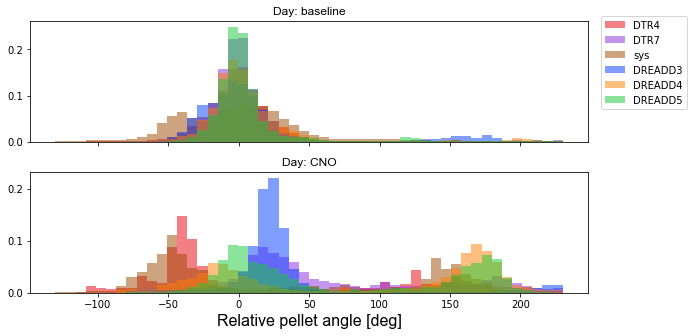

In [20]:
dtr_animals = 2 * ['DTR4'] + 2 * ['DTR7'] + 2 * ['sys']
dtr_days = 3 * [0, 7]

dreadd_animals = 2 * ['DREADD3'] + 2 * ['DREADD4'] + 2 * ['DREADD5']
dreadd_days = 3 * ['baseline', 'CNO']

all_animals = dtr_animals + dreadd_animals
all_days = dtr_days + dreadd_days

day_map = {
    0: 0,
    7: 1,
    'baseline': 0,
    'CNO': 1,
}

colors = sns.color_palette('bright')
color_map = {
    a: colors[i] for i, a in enumerate(full_df['animal_name'].unique())
}


full_df['dots_labeled'] = full_df['bluedot_labeled'] & full_df['reddot_labeled']
labeled_pellet_df = full_df.loc[(full_df['handling'] == True) & (full_df['dots_labeled'] == True)]

probabilities = []
bin_centers = []
animals = []
days = []

f, axs = plt.subplots(2, 1, figsize=(10,5), sharex=True)
for a, d in zip(all_animals, all_days):
    d_index = day_map[d]
    ax = axs[d_index]
    
    if d_index == 1:
            ax.set_xlabel('Relative pellet angle [deg]', fontsize=16, family='Arial')
    
    if d == 'CNO':
        df = labeled_pellet_df.loc[
            (labeled_pellet_df.day.isin(['CNO1', 'CNO2'])) & (labeled_pellet_df['animal_name'] == a)
        ]
    else:
        df = labeled_pellet_df.loc[(labeled_pellet_df['day'] == d) & (labeled_pellet_df['animal_name'] == a)]

    offset_angles = df['offset_angle'].values
    weights = np.ones_like(offset_angles)/len(offset_angles)
    n, bins, _ = ax.hist(
        offset_angles * 180/np.pi,
        alpha=0.5,
        weights=weights,
        bins=50,
        range=(-130, 230),
        histtype='stepfilled',
        label=a,
        color=color_map[a],
    )

    ax.set_title(f'Day: {d}', family='Arial')
    
    n_bins = len(n)
    bin_center = []
    for i in range(n_bins):
        bin_center.append(np.mean([bins[i], bins[i + 1]]))
    
    probabilities += list(n)
    bin_centers += bin_center
    animals += [a] * n_bins
    if (d == 0) or (d == 'baseline'):
        days+= ['baseline'] * n_bins
    else:
        days += ['inhib'] * n_bins
    
f.subplots_adjust(hspace=0.25)
leg = axs[0].legend(loc='upper center', bbox_to_anchor=(1.1, 1.08))

axs[0].set_yticks((0, 0.1, 0.2))
axs[1].set_yticks((0, 0.1, 0.2))

f.savefig('handling_angle_histogram.pdf', bbox_extra_artists=[leg], bbox_inches='tight')

pellet_angle_hist_df = pd.DataFrame(
    {
        'animal_name': animals,
        'day': days,
        'bin_center': bin_centers,
        'probability': probabilities
    }
)


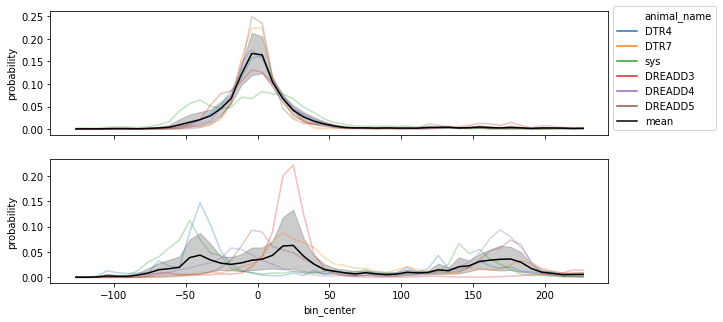

In [41]:
f, axs = plt.subplots(2, 1, figsize=(10,5), sharex=True)

for i, d in enumerate(['baseline', 'inhib']):
    df = pellet_angle_hist_df.loc[pellet_angle_hist_df['day'] == d]
    
    ax = axs[i]
    
    if d == 'baseline':
        leg_type = 'brief'
    else:
        leg_type = False

    ax = sns.lineplot(x='bin_center', y='probability', hue='animal_name',legend=leg_type, data=df, ax=ax, alpha=0.3)

    ax = sns.lineplot(x='bin_center', y='probability', data=df, ax=ax, legend=False, color='black', label='mean')
    
leg = axs[0].legend(loc='upper center', bbox_to_anchor=(1.1, 1.08)) 
f.savefig('angle_hist_lines.png', dpi=300, bbox_inches='tight')
f.savefig('angle_hist_lines.pdf', bbox_inches='tight')

In [17]:
bin_centers

[[-126.4,
  -119.19999999999999,
  -112.0,
  -104.80000000000001,
  -97.6,
  -90.4,
  -83.19999999999999,
  -76.0,
  -68.80000000000001,
  -61.6,
  -54.4,
  -47.199999999999996,
  -39.99999999999999,
  -32.8,
  -25.6,
  -18.4,
  -11.199999999999996,
  -4.0,
  3.200000000000003,
  10.400000000000006,
  17.60000000000001,
  24.80000000000001,
  32.0,
  39.2,
  46.400000000000006,
  53.60000000000001,
  60.80000000000001,
  68.0,
  75.2,
  82.4,
  89.60000000000001,
  96.80000000000001,
  104.0,
  111.2,
  118.4,
  125.6,
  132.8,
  140.00000000000003,
  147.20000000000002,
  154.4,
  161.6,
  168.8,
  176.00000000000003,
  183.20000000000002,
  190.4,
  197.6,
  204.8,
  212.00000000000003,
  219.20000000000002,
  226.4],
 [-126.4,
  -119.19999999999999,
  -112.0,
  -104.80000000000001,
  -97.6,
  -90.4,
  -83.19999999999999,
  -76.0,
  -68.80000000000001,
  -61.6,
  -54.4,
  -47.199999999999996,
  -39.99999999999999,
  -32.8,
  -25.6,
  -18.4,
  -11.199999999999996,
  -4.0,
  3.20000000